# TP1

- Autor: Leandro Saraco
- Mayo 2024

## Consigna

### Parte 1 (imágenes en white_patch y coord_cromaticas) 

1. Implementar el algoritmo de pasaje a coordenadas cromáticas para librarnos de las variaciones de contraste.
2. Implementar el algoritmo White Patch para librarnos de las diferencias de color de iluminación.
3. Mostrar los resultados obtenidos y analizar las posibles fallas (si es que las hay) en el caso de White
patch

### Parte 2:
1. Para las imágenes img1_tp.png y img2_tp.png leerlas con OpenCV en escala de grisas y visualizarlas.
2. Elija el numero de bins que crea conveniente y grafique su histograma, compare los histogramas entre si. Explicar lo que se observa, si tuviera que entrenar un modelo de clasificación/detección de imágenes, considera que puede ser de utilidad tomar como ‘ features ’ a los histogramas?
3. Para la imagen segmentacion.png analice el histograma de los canales RGB. Segmente algunos de los elementos presentes en la imagen (agua, cielo, tierra) y muestre, aplicando mascaras, las regiones en imágenes separadas.

In [2]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import os

## Parte 1 

### 1. Implementar el algoritmo de pasaje a coordenadas cromáticas para librarnos de las variaciones de contraste.

In [3]:
def coord_chromaticas_fast(img):
    """Función que implementa algoritmo de pasaje a coordenadas cromáticas de manera rápida, usando todas funciones de numpy."""    
    channels_sum = np.sum(img,axis=2) #Sumo todos los canales. img es un tensor de 996x908x3
    channels_sume_expanded = channels_sum[...,np.newaxis] #Para poder hacer broadcast y multiplicar una matrix de 996x908x3 por una de 996x908
    # Si todos los canales son 0 no hago división para evitar dividir por 0
    #  Además, si todos los canales en un punto son 0, el canal en cuestión también es 0.
    new_img = np.divide(img,channels_sume_expanded,where=channels_sume_expanded!=0)
    return new_img

def coord_chromaticas_slow(img):
    """Función que implementa algoritmo de pasaje a coordenadas cromáticas a mano, usando ciclos for."""
    channels = cv.split(img)
    channels_new = []
    channels_new_processed = []
    for ch in channels:
        channels_new.append(ch.astype(float))
    for i,ch in enumerate(channels_new):
        new_ch = np.zeros_like(ch).astype(float)
        for x in range(ch.shape[0]):
            for y in range(ch.shape[1]):
                # print(ch[x,y])
                new_ch[x,y] = 0 if ch[x,y]<=0 else ch[x,y] / (channels_new[0][x,y] + channels_new[1][x,y] + channels_new[2][x,y])
                # if y==5:
                #     return
        channels_new_processed.append(new_ch)
    new_img = cv.merge(channels_new_processed)
    return new_img


Text(0.5, 1.0, 'Aplicand algoritmo de coord. cromáticas')

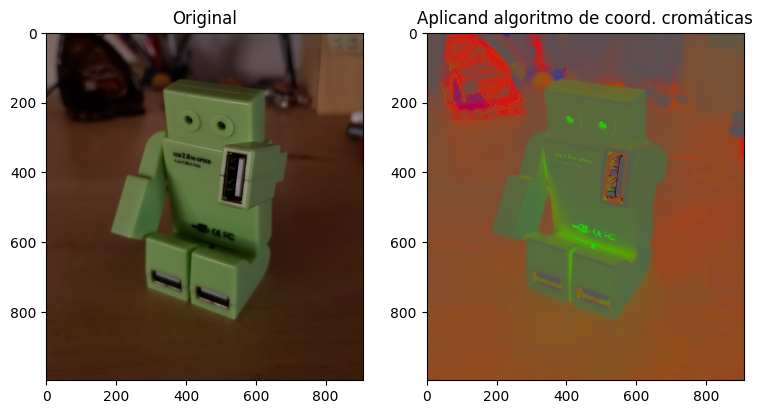

In [4]:
img = cv.imread('./coord_cromaticas/CoordCrom_2.png')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

# Nueva figura
fig = plt.figure(figsize=(9,6))

# Imagen original
ax1=plt.subplot(121)
ax1.imshow(img)
ax1.set_title('Original')

# Imagen luego de aplicar algoritmo de coordenadas cromáticas
ax1=plt.subplot(122)
img_new = coord_chromaticas_fast(img)
ax1.imshow(img_new)
ax1.set_title('Aplicand algoritmo de coord. cromáticas')

### 2. Implementar el algoritmo White Patch para librarnos de las diferencias de color de iluminación.

In [5]:
def white_patch(img):
    """ Función que implementa algoritmo de white patch."""
    channels = cv.split(img)
    channels_new = []
    for ch in channels:
        max_ch = np.max(ch)
        mult =  255/max_ch if max_ch>0 else 0
        ch_ = ch.astype(float)
        # print(f"Max channel: {max_ch}. mult = {mult}")
        new_ch = np.round(mult*ch_,0)
        new_ch = new_ch.astype(np.uint8)
        channels_new.append(new_ch)
    new_img = cv.merge(channels_new)
    return new_img

Text(0.5, 1.0, 'Aplicando algoritmo de white patch')

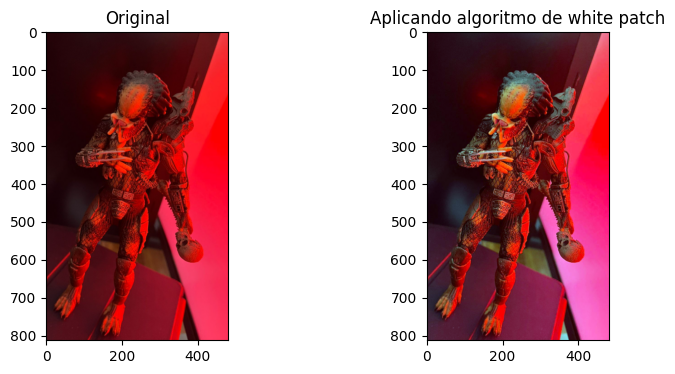

In [6]:
img = cv.imread('./white_patch/wp_red.png')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

# Nueva figura
fig = plt.figure(figsize=(9,4))

# Imagen original
ax1=plt.subplot(121)
ax1.imshow(img)
ax1.set_title('Original')

# Imagen luego de aplicar algoritmo de coordenadas cromáticas
ax1=plt.subplot(122)
img_new = white_patch(img)
ax1.imshow(img_new)
ax1.set_title('Aplicando algoritmo de white patch')

### 3. Mostrar los resultados obtenidos y analizar las posibles fallas (si es que las hay) en el caso de White Patch

- Se muestran los resultados obtenidos al procesar todas las imágenes en las carpetas 'coord_cromaticas' y 'white_patch', con su algoritmo correspondiente.

In [7]:
def procesar_y_mostrar_imagenes(folder_path,proc_function,title):
    """Funcion para procesar y mostrar todas las imagenes de una carpeta."""
    # Lita para guardar tuplas con el formato (original image, processed image, filename)
    image_pairs = []

    # Iteramos sobre todos los archivos de la carpeta
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            file_path = os.path.join(folder_path, filename)
            original_img = cv.imread(file_path)
            if original_img is not None:
                # Convierto de BGR a RGB
                original_img_rgb = cv.cvtColor(original_img, cv.COLOR_BGR2RGB)
                # Aplico la funcion de procesado
                processed_img = proc_function(original_img_rgb)
                # Guardo todo en la tupla
                image_pairs.append((original_img_rgb, processed_img, filename))
            else:
                print(f"Error al leer imagen {filename}")

    # Mutiple plot
    plt.figure(figsize=(8, 4 * len(image_pairs)))
    plt.suptitle(title)
    for index, (original, processed, name) in enumerate(image_pairs):
        # Imagen original
        plt.subplot(len(image_pairs), 2, 2*index + 1)
        plt.imshow(original)
        plt.axis('off')
        plt.title(f"Original: {name}")

        # Imagen procesada
        plt.subplot(len(image_pairs), 2, 2*index + 2)
        plt.imshow(processed,  vmin=0, vmax=255)
        plt.axis('off')
        plt.title(f"Procesada: {name}")

    plt.tight_layout()
    plt.show()


#### Muestro todas las imagenes de ./coord_cromaticas

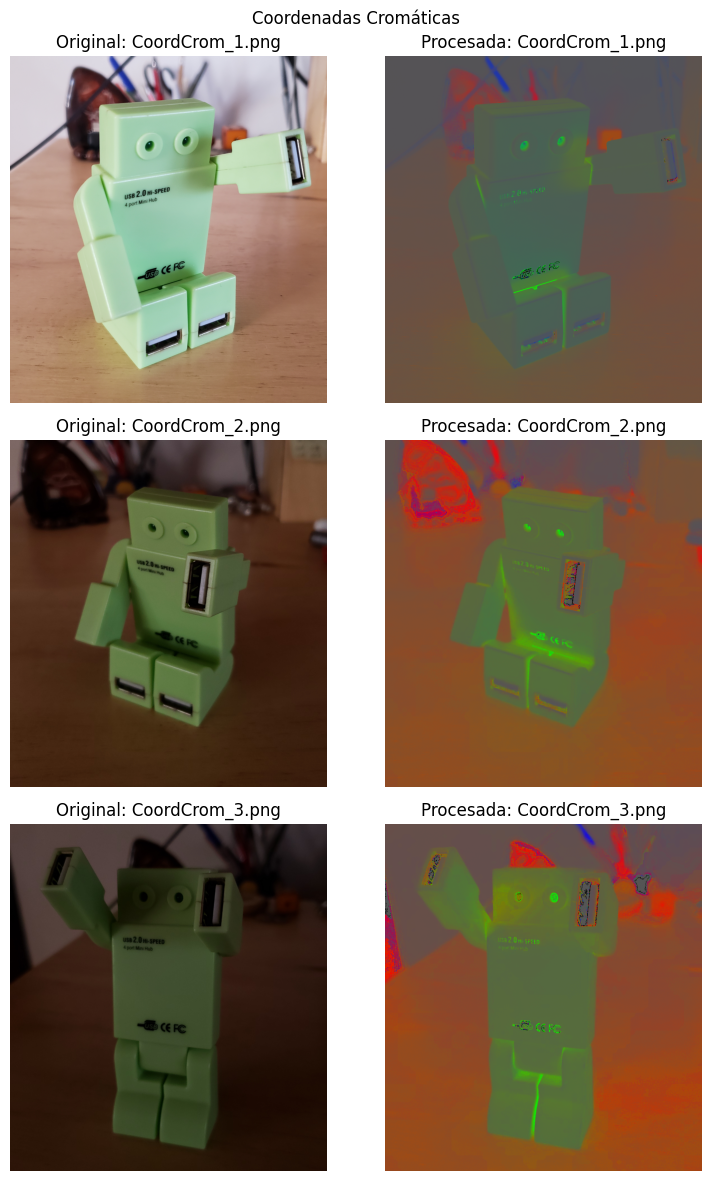

In [8]:
procesar_y_mostrar_imagenes('./coord_cromaticas',coord_chromaticas_fast,"Coordenadas Cromáticas")

#### Muestro todas las imagenes de ./white_patch

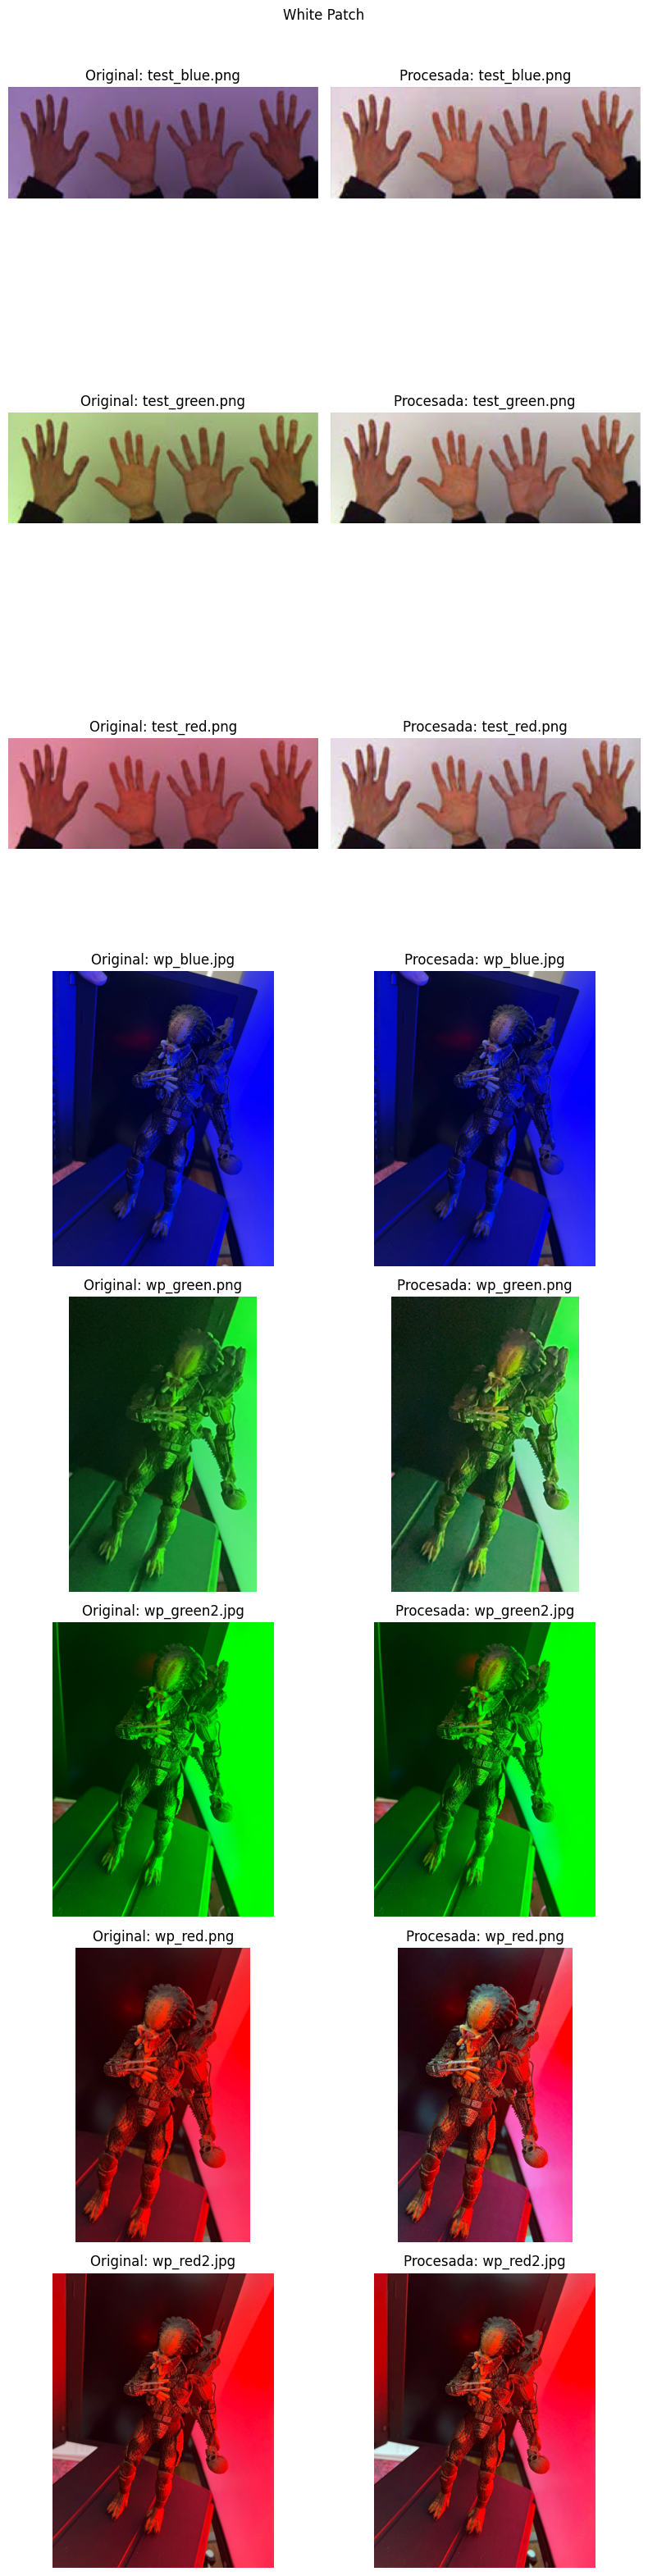

In [9]:
procesar_y_mostrar_imagenes('./white_patch',white_patch, "White Patch")


Posibles fallas de white patch:

- **Saturación**: El multiplicador que se utiliza para cada canal será siempre igual o mayor a 1 (ya que como mucho el máximo en el canal es 255). Esto podría producir que al multiplicar algunos píxeles queden con un valor mayor a 255, el cual será saturado a 255 ya que es el valor máximo de un unit8. 
- **Uso de un máximo global y ruido**: Al utilizar un máximo global, con que un píxel en el canal tenga un valor anormal (por ejemplo una imagen oscura y un píxel en 255 producido por ruido o una anomalía) producirá que el máximo tenga un valor que nos representativo para ese canal, alterando el resultado del algoritmo. Lo mismo ocurre con destellos de luz sobre la imagen.

Estos efectos pueden verse en las imágenes que terminan con un 2, donde se tiene la misma imagen pero tomando un área más grande y con el color más saturado. Se ve que en estos casos el algoritmo tiene menor performance en sentido de lograr un buen balance de blancos.

## Parte 2:
### 1. Para las imágenes img1_tp.png y img2_tp.png leerlas con OpenCV en escala de grisas y visualizarlas.


Text(0.5, 1.0, 'img2_tp.png')

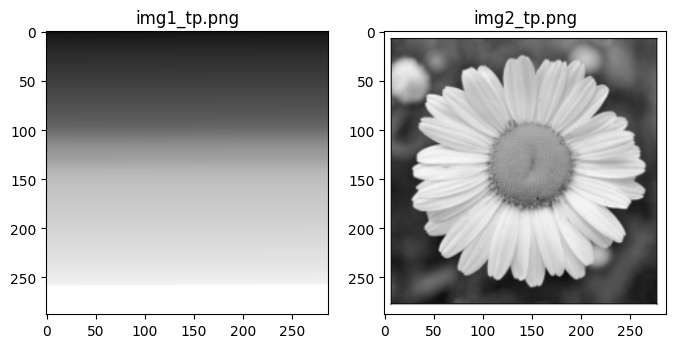

In [10]:
# Nueva figura
fig = plt.figure(figsize=(8,5))

# Leo imagenes
img1 = cv.imread('img1_tp.png', cv.IMREAD_GRAYSCALE)
img2 = cv.imread('img2_tp.png', cv.IMREAD_GRAYSCALE)

# Imagen 1
ax1=plt.subplot(121)
ax1.imshow(img1, cmap='gray', vmin=0, vmax=255)
ax1.set_title('img1_tp.png')

# Imagen 2
ax1=plt.subplot(122)
ax1.imshow(img2, cmap='gray', vmin=0, vmax=255)
ax1.set_title('img2_tp.png')

### 2. Elija el numero de bins que crea conveniente y grafique su histograma, compare los histogramas entre si. Explicar lo que se observa, si tuviera que entrenar un modelo de clasificación/detección de imágenes, considera que puede ser de utilidad tomar como ‘ features ’ a los histogramas?


Se eligen 256 bins para tener detalles de cada nivel de intensidad

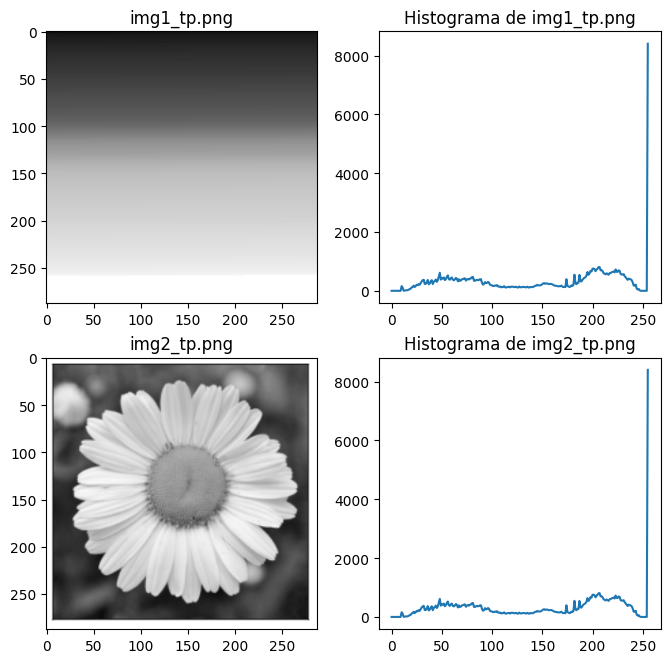

In [11]:
# Nueva figura
fig = plt.figure(figsize=(8,12))

# Funcion que plotea imagen y su histograma
def plot_img_and_hist(img_path,index):
    img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
    ax=plt.subplot(3,2,index)
    ax.imshow(img, cmap='gray', vmin=0, vmax=255)
    ax.set_title(str(img_path))
    hist1,bins1 = np.histogram(img.ravel(),256,[0,256]) #Utilizo 256 bins para tener detalles de cada nivel de intensidad
    ax2=plt.subplot(3,2,index+1)
    ax2.plot(hist1)
    ax2.set_title(f"Histograma de {img_path}")
    return hist1

hist1 = plot_img_and_hist("img1_tp.png",1)
hist2 = plot_img_and_hist("img2_tp.png",3)

Los histogramas son muy parecidos. Para comparar hago un plot de uno encima del otro:

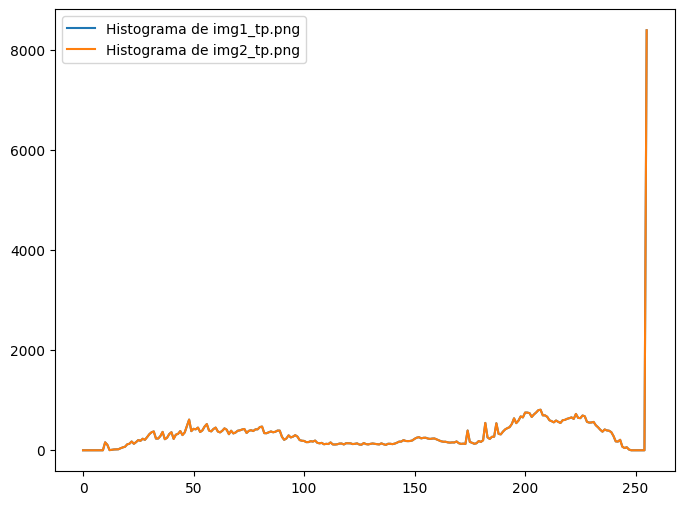

In [12]:
plt.figure(figsize=(8,6))
plt.plot(hist1,label="Histograma de img1_tp.png")
plt.plot(hist2,label="Histograma de img2_tp.png")
plt.legend()

Al ver que las dos imágenes poseen un histograma prácticamente idéntico podemos decir que no sería bueno utilizar solo el hisograma de las imágenes como los únicos features para entrenar un modelo de clasificación de imágenes.

El histograma representa la frecuencia de cada valor de intensidad en cada canal, sin tener en cuenta otro tipo de información importante para la clasificación como la forma que generen los píxeles o su distribución espacial a lo largo de la imágen. 

Por ejemplo, si se toma una imágen con una forma X y se reordenan los píxeles de manera totalmente aleatoria y sin sentido (pero sin alterar su valor) se tendrá el mismo histograma pero se habrá destruido completamente la forma en cuestión que un clasificador podría detectar.

Se concluye entonces que utilizar sólo histogramas para clasificar imágenes podría resultar en resultados muy erróneos, pero que el uso de histogramas podría llegar a ser de utilidad para extraer algún feature que sirva como soporte a algún modelo, o por ejemplo utilizando histogramas por partes como lo hace este algoritmo (HOG): https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients



### 3. Para la imagen segmentacion.png analice el histograma de los canales RGB. Segmente algunos de los elementos presentes en la imagen (agua, cielo, tierra) y muestre, aplicando mascaras, las regiones en imágenes separadas.

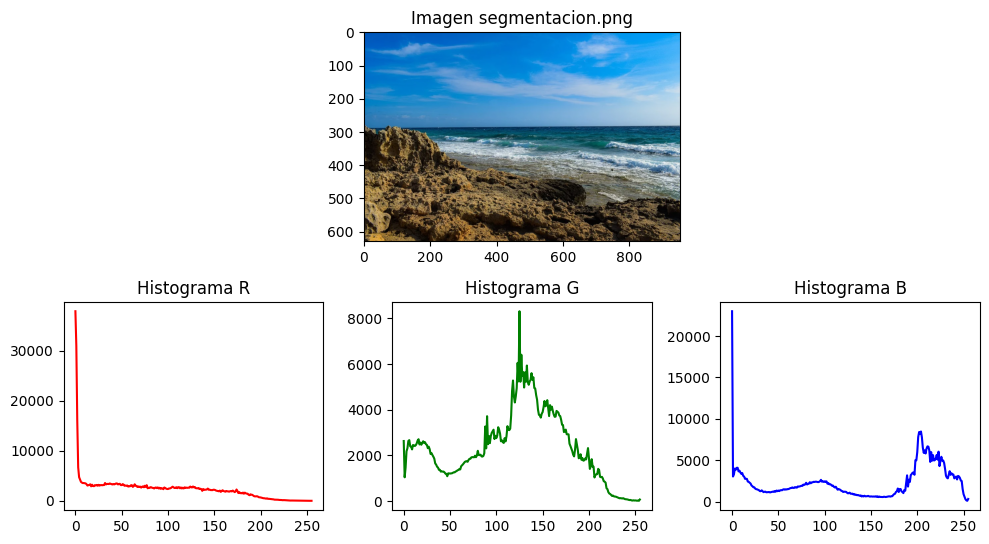

In [13]:
# Cargo imagen, la convierto a RGB y muestro un histograma por canal
img3 = cv.imread("./segmentacion.png",cv.IMREAD_COLOR)
img3_RGB = cv.cvtColor(img3,cv.COLOR_BGR2RGB)
# img3_HSV = cv.cvtColor(img3, cv.COLOR_BGR2HSV)

img3_R,img3_G,img3_B = cv.split(img3_RGB)


# Creo figura con un grid de 3x3
fig = plt.figure(figsize=(10, 8))
gs = GridSpec(3, 3, figure=fig)

# La primera fila es la imagen
ax1 = fig.add_subplot(gs[0, :]) 
ax1.set_title('Imagen segmentacion.png')
ax1.imshow(img3_RGB)  # Example plot data

# Obtengo histograma del canal R y lo ploteo
ax2 = fig.add_subplot(gs[1, 0]) 
ax2.set_title('Histograma R')
hist3_R, _ = np.histogram(img3_R.ravel(),256,[0,256])
ax2.plot(hist3_R,color='r')

# Obtengo histograma del canal R y lo ploteo
ax3 = fig.add_subplot(gs[1, 1]) 
ax3.set_title('Histograma G')
hist3_G, _ = np.histogram(img3_G.ravel(),256,[0,256])
ax3.plot(hist3_G,color='g')

# Obtengo histograma del canal R y lo ploteo
ax4 = fig.add_subplot(gs[1, 2]) 
ax4.set_title('Histograma B')
hist3_B, _ = np.histogram(img3_B.ravel(),256,[0,256])
ax4.plot(hist3_B,color='b')

# Automatically adjust subplot parameters to give specified padding
plt.tight_layout()
plt.show()


Para tener más detalles en el análisis muestro una imagen independiente de cada canal

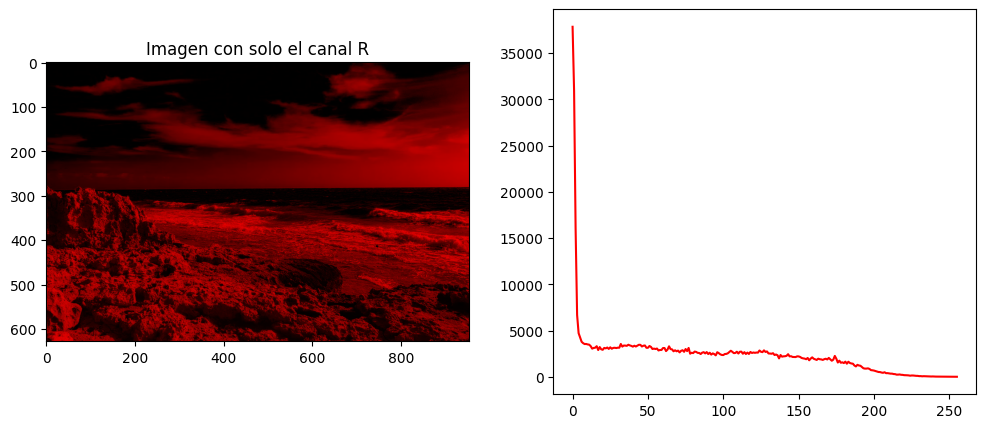

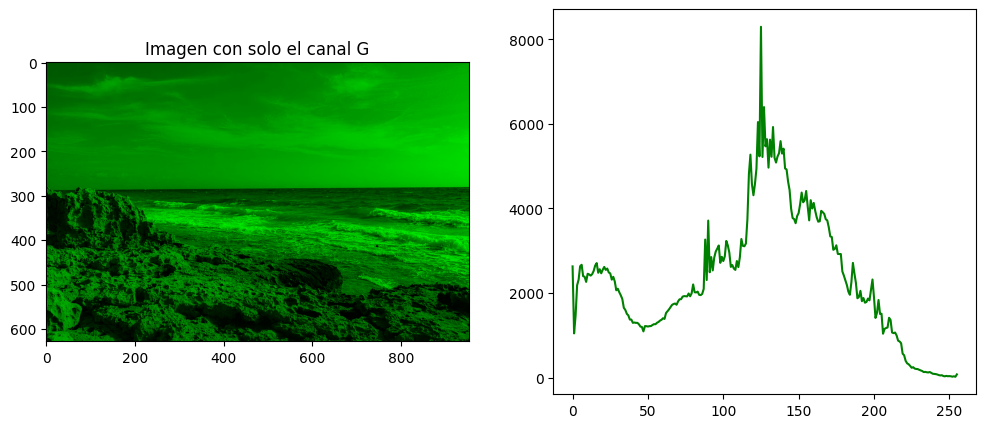

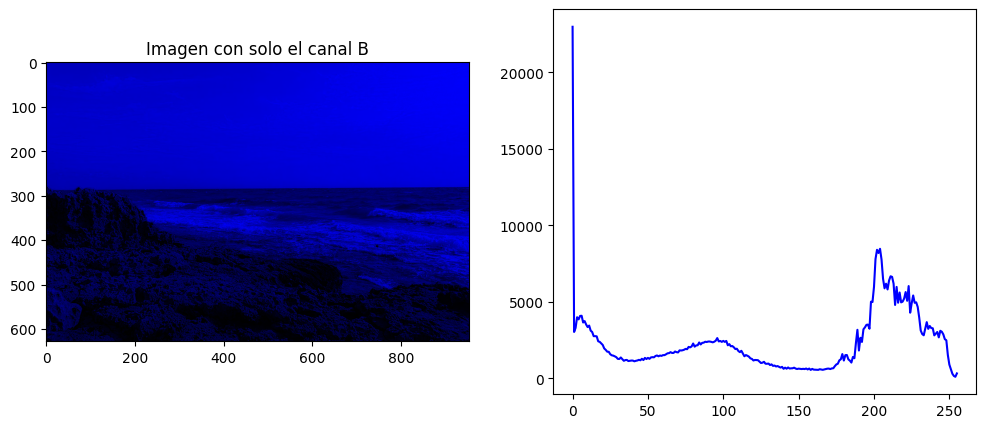

In [15]:
def mostrar_imagen_canal(img_rgb, canal):
    """Muestra una imagen de un solo canal, anulando los otros."""
    labels = "RGB"
    chs = cv.split(img_rgb)
    mult = np.zeros(3).astype(np.uint8)
    mult[canal] = 1
    ch_monocromatico = cv.merge([chs[i]*mult[i] for i in range(3)])
    # plt.figure(figsize=(12,5))
    fig,ax = plt.subplots(1,2,figsize=(12,5))
    ax[0].imshow(ch_monocromatico)
    ax[0].set_title(f"Imagen con solo el canal {labels[canal]}")
    hist, _ = np.histogram(chs[canal],bins=256)
    ax[1].plot(hist,color=labels[canal].lower())
    plt.show()
    return (ch_monocromatico,hist)

img3_R, _ = mostrar_imagen_canal(img3_RGB,0)
img3_G, _ = mostrar_imagen_canal(img3_RGB,1)
img3_B, _ = mostrar_imagen_canal(img3_RGB,2)

Del análisis puede verse que:

- Se podría extraer el cielo del canal azul (B), quedandonos con los valores entre 160 y 250.
- Se podría extraer el mar a partir de los valores bajos del canal azul.
- Se podrían extraer las olas del canal verde (G).

Para verificar esto se tomarán muestras de cada parte y se intentarán extraer utilizando máscaras.

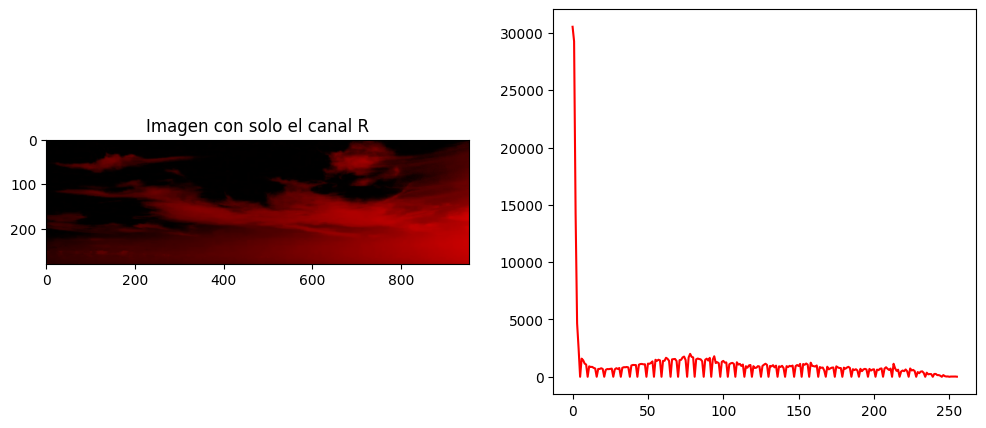

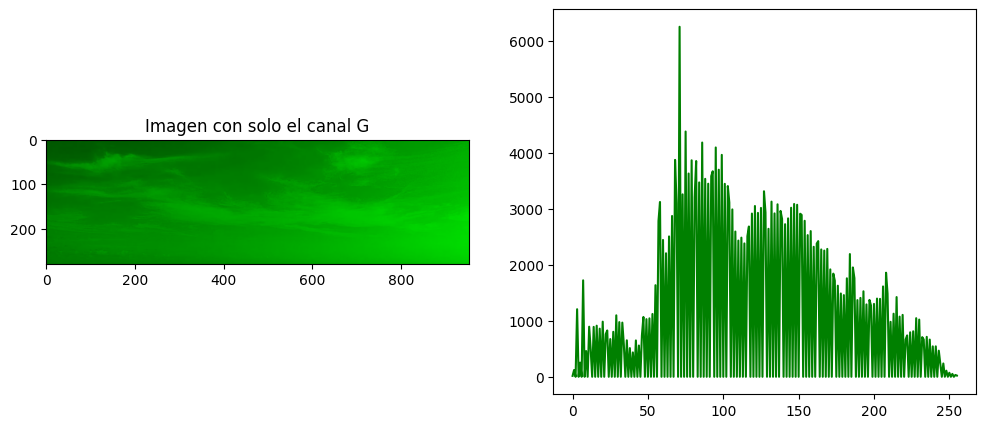

Media: 215.714 Desvio estandar: 16.568


In [89]:
# Tomo muestra del cielo
muestra = img3_RGB[0:280,:,:]
mostrar_imagen_canal(muestra,0)
mostrar_imagen_canal(muestra,1)
mostrar_imagen_canal(muestra,2)
color_mean, color_std = cv.meanStdDev(muestra)
media = color_mean[2,0]
desvio = color_std[2,0]
print(f"Media: {media:.3f} Desvio estandar: {desvio:.3f}")

A partir de este análisis intento segmentar el mar:

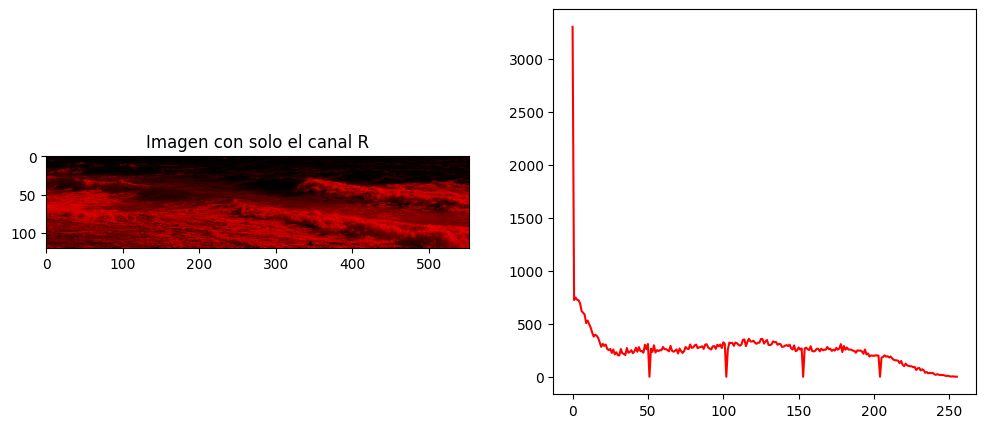

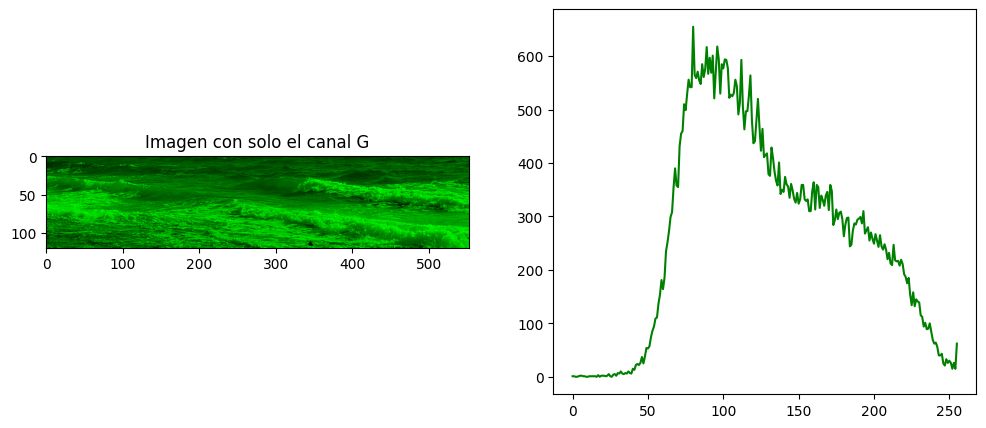

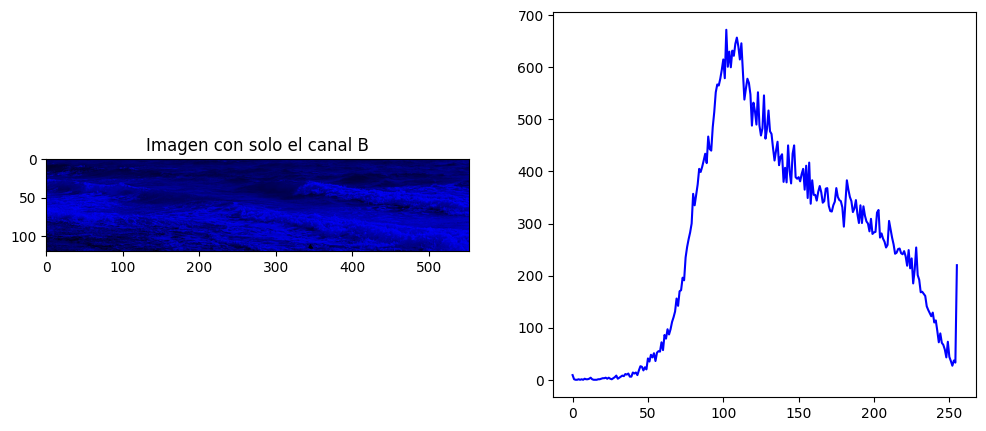

True

In [97]:
# Tomo muestra del mar
muestra = img3_RGB[300:420,400:,:]
mostrar_imagen_canal(muestra,0)
mostrar_imagen_canal(muestra,1)
mostrar_imagen_canal(muestra,2)
True

Text(0.5, 1.0, 'Máscara')

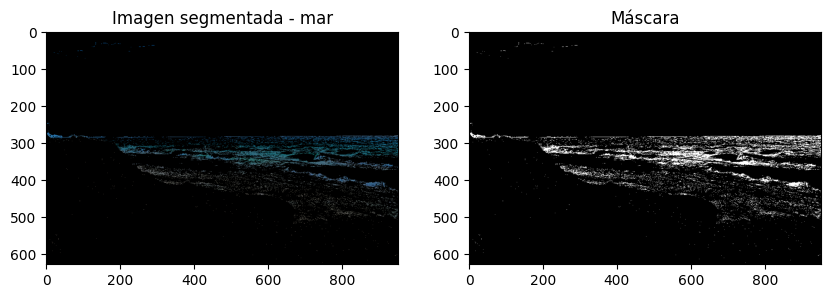

In [154]:
n_sigma = 3
mask = cv.inRange(img3_RGB, np.array([12,60,100]), np.array([255,118,255]))
img3_mar = cv.bitwise_and(img3_RGB, img3_RGB, mask=mask)

plt.figure(figsize=(10,15))
ax1 = plt.subplot(121)
ax1.imshow(img3_mar)
ax1.set_title("Imagen segmentada - mar")
ax2 = plt.subplot(122)
ax2.imshow(mask,cmap='gray')
ax2.set_title("Máscara")

Ahora el cielo:

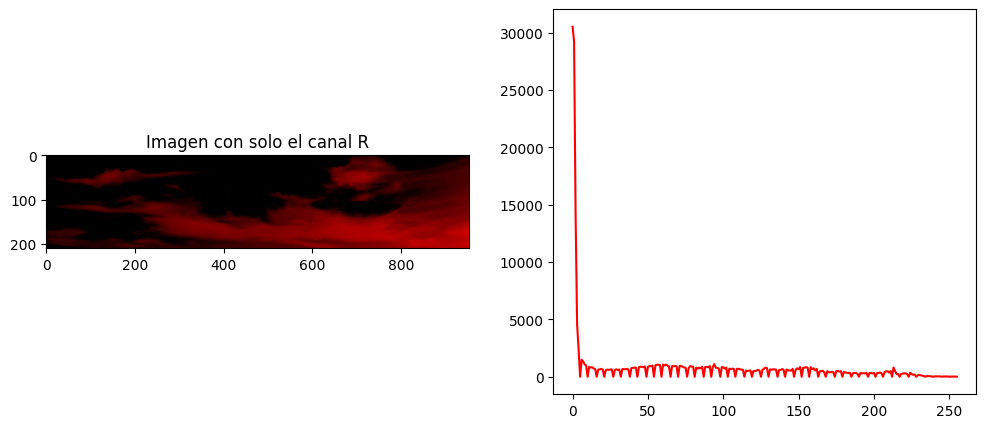

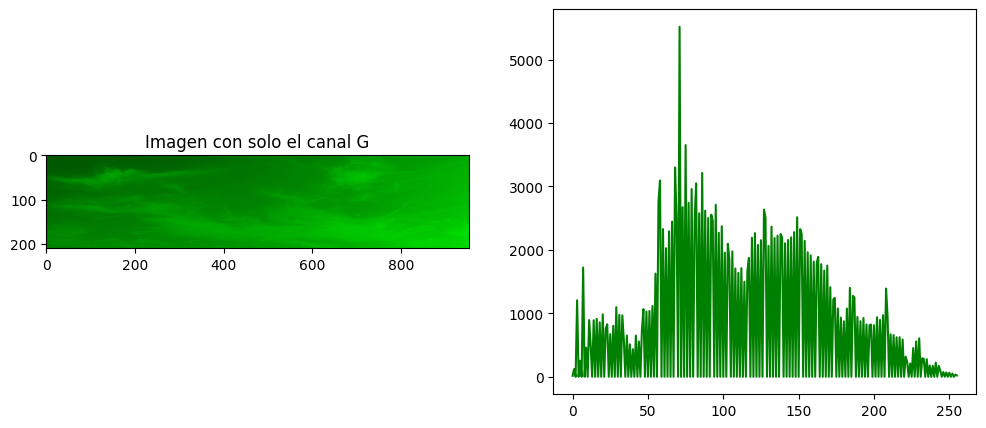

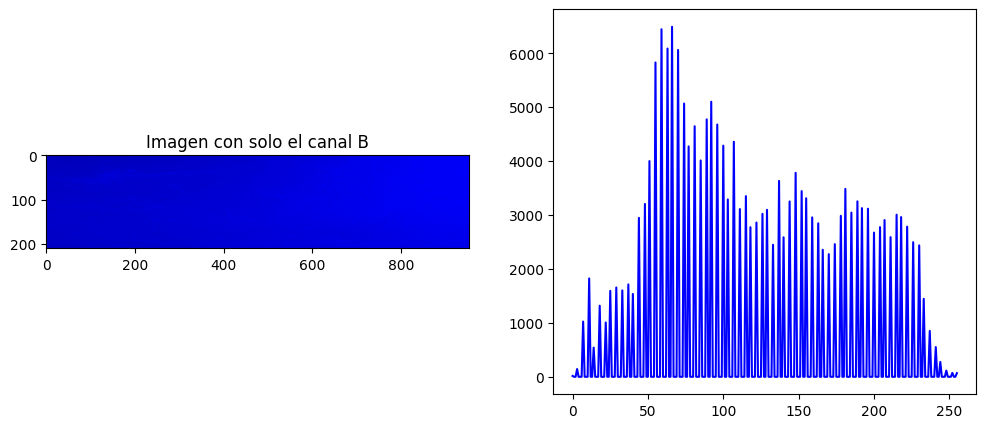

True

In [111]:
muestra = img3_RGB[0:210,::,:]
mostrar_imagen_canal(muestra,0)
mostrar_imagen_canal(muestra,1)
mostrar_imagen_canal(muestra,2)
True #Para evitar que imprima todo el array, que Jupyter imprima solo True

Media: 218.436586 Desvio estandar: 16.239812


Text(0.5, 1.0, 'Máscara')

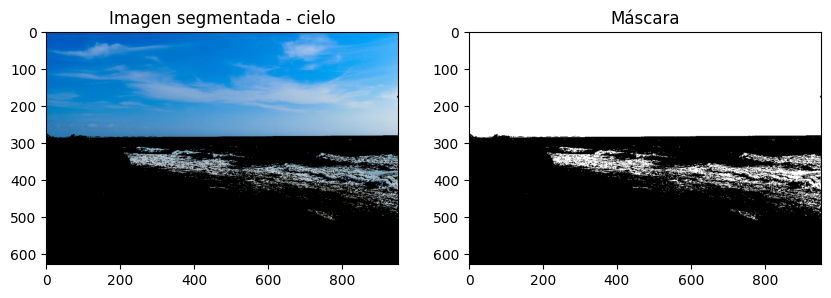

In [124]:
color_mean, color_std = cv.meanStdDev(muestra)
media = color_mean[2,0]
desvio = color_std[2,0]
print(f"Media: {media:f} Desvio estandar: {desvio:f}")

n_sigma = 3
mask = cv.inRange(img3_RGB, np.array([0,80,media-desvio*n_sigma]), np.array([207,225,media+desvio*n_sigma]))
img3_cielo = cv.bitwise_and(img3_RGB, img3_RGB, mask=mask)


plt.figure(figsize=(10,15))
ax1 = plt.subplot(121)
ax1.imshow(img3_cielo)
ax1.set_title("Imagen segmentada - cielo")
ax2 = plt.subplot(122)
ax2.imshow(mask,cmap='gray')
ax2.set_title("Máscara")

Por otro lado, podemos sacar todo lo que tenga tono azul como el mar y el cielo para quedarnos con la tierra

In [18]:
n_sigma = 3
mask = cv.inRange(img3_RGB, np.array([0,0,0]), np.array([255,255,50]))
img3_tierra = cv.bitwise_and(img3_RGB, img3_RGB, mask=mask)

plt.figure(figsize=(10,15))
ax1 = plt.subplot(121)
ax1.imshow(img3_tierra)
ax1.set_title("Imagen segmentada - tierra")
ax2 = plt.subplot(122)
ax2.imshow(mask,cmap='gray')
ax2.set_title("Máscara")

Text(0.5, 1.0, 'Máscara')